# Setup

In [1]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import torch
from torch import nn

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Helpers

In [3]:
def get_data_from_matlab(file_path: str) -> pd.DataFrame:
    raw_data: dict = loadmat(file_path)
    dict_keys: list = list(raw_data.keys())
    data = raw_data[dict_keys[-1]]
    df = pd.DataFrame(data.T)
    return df

# Preprocessing

In [4]:
xs = get_data_from_matlab("/home/gabriel/Downloads/xs_file.mat")
tau = get_data_from_matlab("/home/gabriel/Downloads/tau_file.mat")

# xs = xs[10000:]
# tau = tau[10000:]

tau.columns = [
    "U_1", 
    "U_2", 
    "U_3", 
    "U_4"
]
xs.columns = [
    "x_dot",
    "y_dot",
    "z_dot",
    "phi_dot",
    "theta_dot",
    "psi_dot",
    "x",
    "y",
    "z",
    "phi",
    "theta",
    "psi",
]

print(20*'=')
print('xs')
display(xs)
print(20*'=')
print('tau')
display(tau)

xs


,x_dot,y_dot,z_dot,phi_dot,theta_dot,psi_dot,x,y,z,phi,theta,psi
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.500000
1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.500000
2,0.000000e+00,0.000000e+00,3.300000e-03,0.000000,0.000000,-0.010823,0.000000e+00,0.000000e+00,0.000002,0.000000e+00,0.000000,0.499995
3,0.000000e+00,0.000000e+00,6.600000e-03,-0.000290,0.011880,-0.021645,0.000000e+00,0.000000e+00,0.000007,-1.451302e-07,0.000006,0.499978
4,6.739599e-08,3.898365e-08,9.893398e-03,-0.000582,0.023756,-0.032444,3.369799e-11,1.949182e-11,0.000015,-5.811928e-07,0.000024,0.499951
...,...,...,...,...,...,...,...,...,...,...,...,...
39996,-2.463004e-01,1.270376e-01,6.102129e-10,0.003236,0.006277,-0.000001,2.521097e-01,4.865880e-01,3.000000,1.240103e-02,-0.006422,0.000002
39997,-2.463634e-01,1.269160e-01,6.047102e-10,0.003233,0.006279,-0.000001,2.518634e-01,4.867150e-01,3.000000,1.240426e-02,-0.006415,0.000002
39998,-2.464264e-01,1.267943e-01,5.992070e-10,0.003230,0.006281,-0.000001,2.516170e-01,4.868418e-01,3.000000,1.240749e-02,-0.006409,0.000002
39999,-2.464892e-01,1.266725e-01,5.937031e-10,0.003227,0.006282,-0.000001,2.513705e-01,4.869686e-01,3.000000,1.241072e-02,-0.006403,0.000002


tau


,U_1,U_2,U_3,U_4
0,21.582000,0.000000,0.000000,0.000000e+00
1,28.842000,0.000000,0.000000,-2.500000e-01
2,28.842000,-0.004847,0.198399,-2.500000e-01
3,28.827476,-0.004865,0.198325,-2.494562e-01
4,28.812944,-0.004862,0.187051,-2.489069e-01
...,...,...,...,...
39996,21.584105,-0.000052,0.000027,-8.427434e-07
39997,21.584105,-0.000052,0.000027,-8.421519e-07
39998,21.584105,-0.000052,0.000027,-8.415595e-07
39999,21.584105,-0.000052,0.000027,-8.409663e-07


# EDA

In [5]:
t = np.linspace(0,1,len(xs))
plt.style.use('duarte.mplstyle')

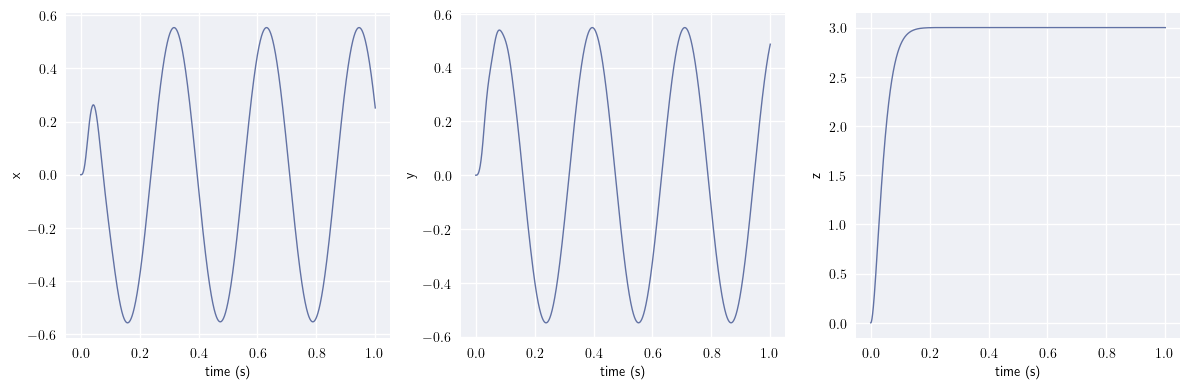

In [6]:
fig, axs = plt.subplots(1,3, figsize=(12,4))

names = ['x', 'y', 'z']
for i, ax in enumerate(axs.flatten()):
    ax.plot(t, xs[names[i]])
    ax.set_xlabel('time (s)')
    ax.set_ylabel(names[i])
fig.tight_layout()

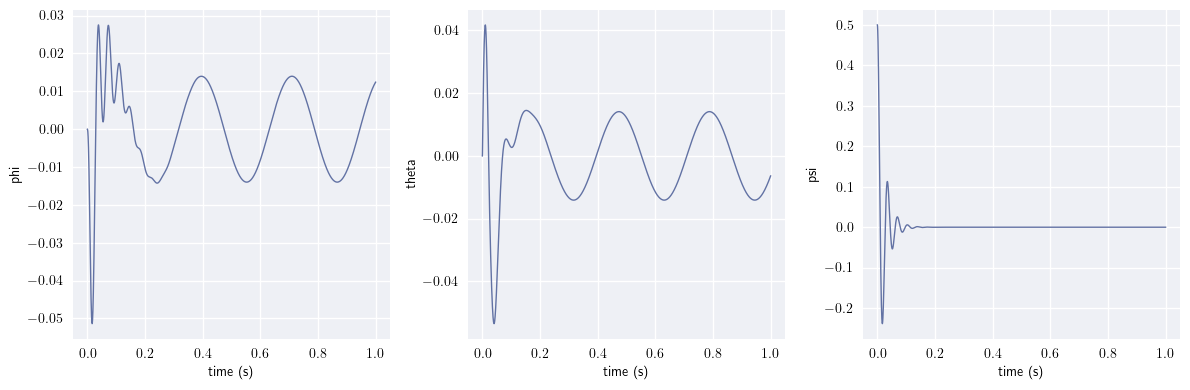

In [7]:
fig, axs = plt.subplots(1,3, figsize=(12,4))

names = ['phi', 'theta', 'psi']
for i, ax in enumerate(axs.flatten()):
    ax.plot(t, xs[names[i]])
    ax.set_xlabel('time (s)')
    ax.set_ylabel(names[i])
fig.tight_layout()

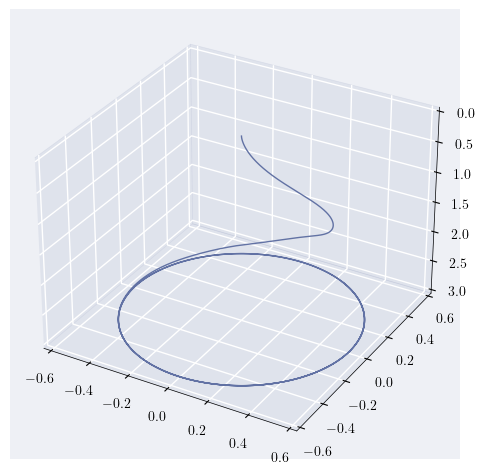

In [8]:
fig, ax = plt.subplots(subplot_kw=dict(projection="3d"))

ax.plot(xs['x'], xs['y'], xs['z'])
ax.invert_zaxis()
fig.tight_layout()

# Modeling

In [9]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(12, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 4)
        )

    def forward(self, x):
        return self.layers(x)

In [10]:
test_split = int(0.8*len(xs))
X_train, X_test = xs[:test_split], xs[test_split:]
y_train, y_test = tau[:test_split], tau[test_split:]

X_train, X_test = torch.Tensor(X_train.values), torch.Tensor(X_test.values)
y_train, y_test = torch.Tensor(y_train.values), torch.Tensor(y_test.values)

print('Splitting: ', test_split)
print(30*'=')
print(f'Lenght of X_train : {len(X_train):>10}')
print(f'Lenght of X_test  : {len(X_test):>10}')
print(f'Lenght of y_train : {len(y_train):>10}')
print(f'Lenght of y_test  : {len(y_test):>10}')

Splitting:  32000
Lenght of X_train :      32000
Lenght of X_test  :       8001
Lenght of y_train :      32000
Lenght of y_test  :       8001


In [11]:
modelnn = Model()
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(modelnn.parameters())

In [12]:
torch.manual_seed(42)

epochs = 501

train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in tqdm(range(epochs)):
    modelnn.train()
    y_pred = modelnn(X_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    modelnn.eval()
    with torch.inference_mode():
        test_pred = modelnn(X_test)

      # 2. Caculate loss on test data
        test_loss = loss_fn(test_pred, y_test.type(torch.float))

      # Print out what's happening
        if epoch % 100 == 0:
              epoch_count.append(epoch)
              train_loss_values.append(loss.detach().numpy())
              test_loss_values.append(test_loss.detach().numpy())
              print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

  0%|          | 2/501 [00:00<01:15,  6.60it/s]

Epoch: 0 | MAE Train Loss: 5.428175449371338 | MAE Test Loss: 5.39669942855835 


 21%|██        | 103/501 [00:17<00:50,  7.86it/s]

Epoch: 100 | MAE Train Loss: 0.16951385140419006 | MAE Test Loss: 0.10525083541870117 


 40%|████      | 202/501 [00:30<00:41,  7.20it/s]

Epoch: 200 | MAE Train Loss: 0.04185065999627113 | MAE Test Loss: 0.020483845844864845 


 60%|██████    | 303/501 [00:46<00:21,  9.23it/s]

Epoch: 300 | MAE Train Loss: 0.03358355164527893 | MAE Test Loss: 0.042412906885147095 


 80%|████████  | 403/501 [00:57<00:09, 10.76it/s]

Epoch: 400 | MAE Train Loss: 0.0247491542249918 | MAE Test Loss: 0.014870163053274155 


100%|██████████| 501/501 [01:05<00:00,  7.61it/s]

Epoch: 500 | MAE Train Loss: 0.02325299009680748 | MAE Test Loss: 0.016036733984947205 


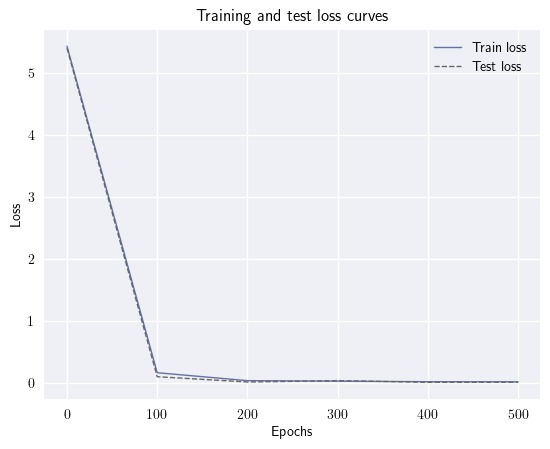

In [13]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

# Inference

In [14]:
modelnn.eval()
with torch.inference_mode():
    preds = modelnn(X_test)
preds = preds.numpy()
preds

array([[ 2.15365543e+01, -1.39669776e-02, -5.45781106e-03,
        -1.86944380e-02],
       [ 2.15365562e+01, -1.39664710e-02, -5.45899570e-03,
        -1.86915621e-02],
       [ 2.15365696e+01, -1.39658125e-02, -5.45995310e-03,
        -1.86889544e-02],
       ...,
       [ 2.15518665e+01, -1.05884839e-02, -7.08297268e-03,
        -1.26169845e-02],
       [ 2.15518456e+01, -1.05871838e-02, -7.08175451e-03,
        -1.26137212e-02],
       [ 2.15518246e+01, -1.05857830e-02, -7.08091632e-03,
        -1.26106516e-02]], dtype=float32)

In [15]:
len(preds)

8001

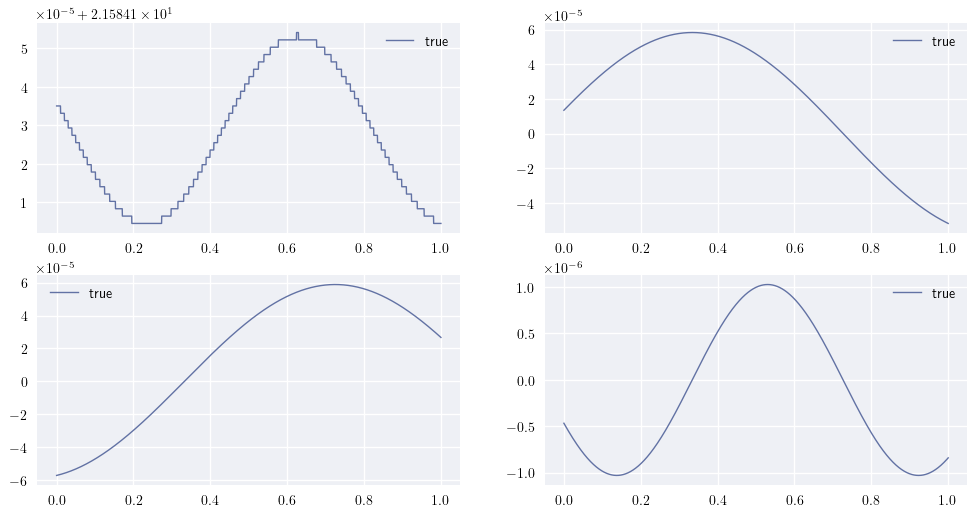

In [16]:
fig, axs = plt.subplots(2,2, figsize=(12,6))

t = np.linspace(0,1,len(preds))

for i, ax in enumerate(axs.flatten()):
    # ax.plot(t, preds[:, i], label='preds')
    ax.plot(t, y_test.numpy()[:, i], label='true')
    ax.legend()


In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(xs, tau, shuffle=False, test_size=0.2)

In [19]:
model = RandomForestRegressor()

In [20]:
model.fit(X_train, y_train)

RandomForestRegressor()

In [21]:
preds = model.predict(X_test)

In [22]:
model.score(X_test, y_test)

0.9999662199396124

In [23]:
preds = model.predict(X_test)

In [24]:
len(preds)

8001

In [25]:
t = np.linspace(0,1,len(preds))

In [26]:
y_test_inference = y_test.values
y_test_inference

array([[ 2.15841360e+01,  1.35188164e-05, -5.71505891e-05,
        -4.67362366e-07],
       [ 2.15841360e+01,  1.35472187e-05, -5.71435482e-05,
        -4.68278468e-07],
       [ 2.15841360e+01,  1.35756177e-05, -5.71364930e-05,
        -4.69194104e-07],
       ...,
       [ 2.15841046e+01, -5.18121924e-05,  2.67618507e-05,
        -8.41559519e-07],
       [ 2.15841046e+01, -5.18256719e-05,  2.67356176e-05,
        -8.40966298e-07],
       [ 2.15841046e+01, -5.18391385e-05,  2.67093779e-05,
        -8.40372238e-07]])

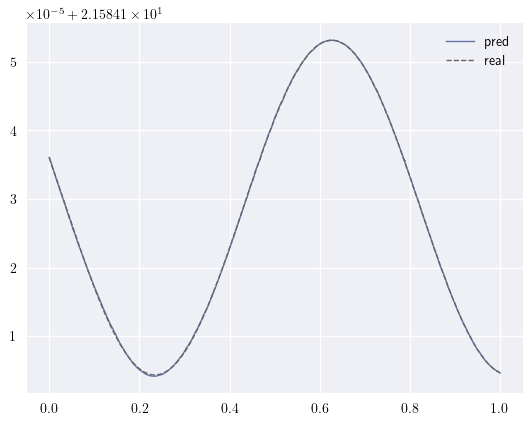

In [27]:
plt.plot(t, preds[:, 0], label='pred')
plt.plot(t, y_test_inference[:, 0], label='real')
plt.legend()

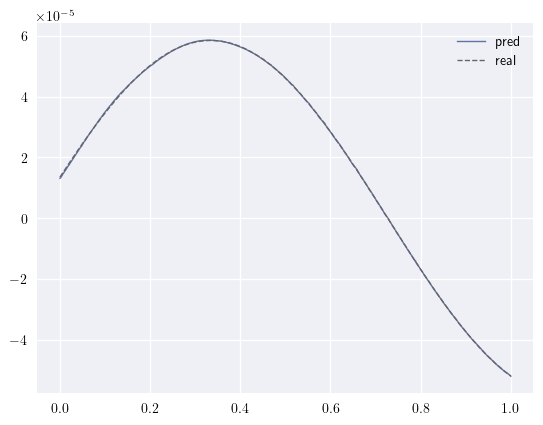

In [28]:
plt.plot(t, preds[:, 1], label='pred')
plt.plot(t, y_test_inference[:, 1], label='real')
plt.legend()

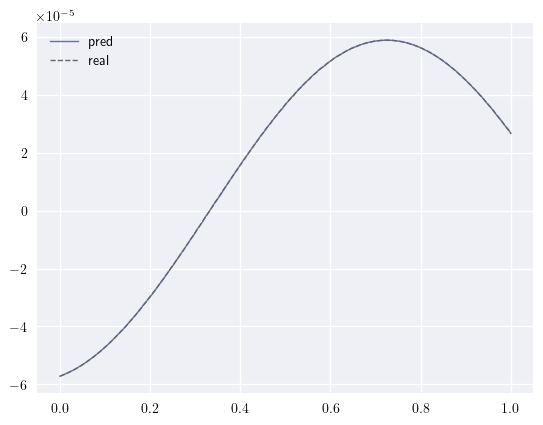

In [29]:
plt.plot(t, preds[:, 2], label='pred')
plt.plot(t, y_test_inference[:, 2], label='real')
plt.legend()

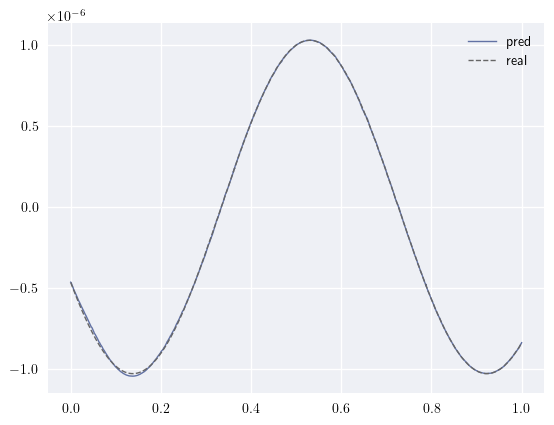

In [30]:
plt.plot(t, preds[:, 3], label='pred')
plt.plot(t, y_test_inference[:, 3], label='real')
plt.legend()

In [37]:
xs_ret = get_data_from_matlab('/home/gabriel/Downloads/xs_file_ret.mat')
tau_ret = get_data_from_matlab('/home/gabriel/Downloads/tau_file_ret.mat')

In [38]:
tau_ret.columns = [
    "U_1", 
    "U_2", 
    "U_3", 
    "U_4"
]
xs_ret.columns = [
    "x_dot",
    "y_dot",
    "z_dot",
    "phi_dot",
    "theta_dot",
    "psi_dot",
    "x",
    "y",
    "z",
    "phi",
    "theta",
    "psi",
]

In [40]:
preds_ret = model.predict(xs_ret.values)

/usr/lib64/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


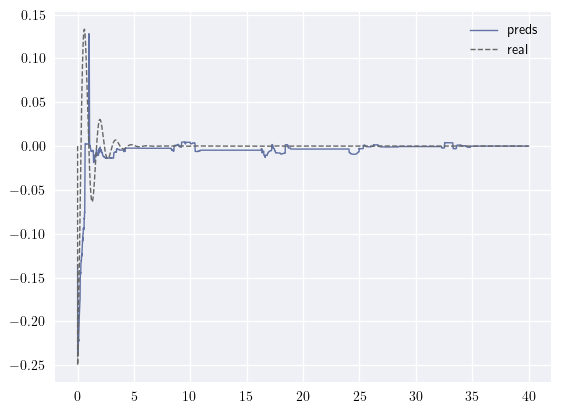

In [46]:
t = np.linspace(0,40,40001)
plt.plot(t, preds_ret[:, 3], label='preds')
plt.plot(t, tau_ret.values[:, 3], label='real')
plt.legend()